# Functional Encryption - Classification and information leakage

Our start point is the work on encrypted classification using Function Encryption of the paper [Reading in the Dark: Classifying Encrypted Digits with Functional Encryption](https://eprint.iacr.org/2018/206), and the associated [GitHub repository](https://github.com/edufoursans/reading-in-the-dark).

More specifically, the paper provides a new Functional Encryption scheme for quadratic multi-variate polynomials, which can under some hypothesis be seen as a single hidden layer neural network with a quadratic activation.
In the paper, the output corresponds to element per class, and it is made in clear. We analyse how this output can disclose information about the initial input or about charasteristics of this input.

To this aim, we have just built a dataset which is very similar to MNIST, used in the original paper but which is composed of 26 letter characters of 5 differents fonts. Our goal is two-fold:
 - Evaluate how the output in clear can be leverage with a public NN to make better prediction than a simple `argmax` function in the character recognition task.
 - Analyse to what extent the output in clear of the model trained for character recognition can reveal information about the font used, using an "adversarial" network.
 
We have used the output and modified the output of our quadratic net to improve the character classification accuracy. But can we use this now this output of the private model that we freeze, in order to learn to perform another _adversarial_ classification task, where we want instead to detect the font of the letter used.

# 3 Collateral Learning


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [1]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import learn
from learn import main, train, test, show_results, show_confusion_matrix

## 3.1 Loading the quadratic baseline
Let's train the baseline model and this how we can use its output to train a "adversarial/collateral" network!

In [3]:
class QuadNet(nn.Module):
    def __init__(self, output_size):
        super(QuadNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, output_size)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return F.log_softmax(x, dim=1)
    
    def transform(self, x):
        """Same as forward but without the log_softmax"""
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x

In [4]:
results = {}
quad_model = QuadNet(26)
results['QuadNet'], model, pred_labels = main(model=quad_model, model_type='quad', task='char', return_model=True, return_pred_label=True)

Training set 60000 items
Testing set  10000 items
Learning on char with quad 
Train Epoch: 1 [0/60000 (0%)]	Loss: 3.566816
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.068456
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.743918
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.899912

Test set: Average loss: 0.4613, Accuracy: 8620/10000 (86.20%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.556004
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.520704
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.547655
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.548369

Test set: Average loss: 0.3148, Accuracy: 9089/10000 (90.89%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.729023
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.406217
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.516341
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.624141

Test set: Average loss: 0.2497, Accuracy: 9291/10000 (92.91%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.482792
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.415880
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.667348


We save the model so that we won't have to train it again. _Make sure have the correct path and directories._

In [5]:
torch.save(model.state_dict(), '../data/models/quad_char.pt')

Let's also show the confusion matrix

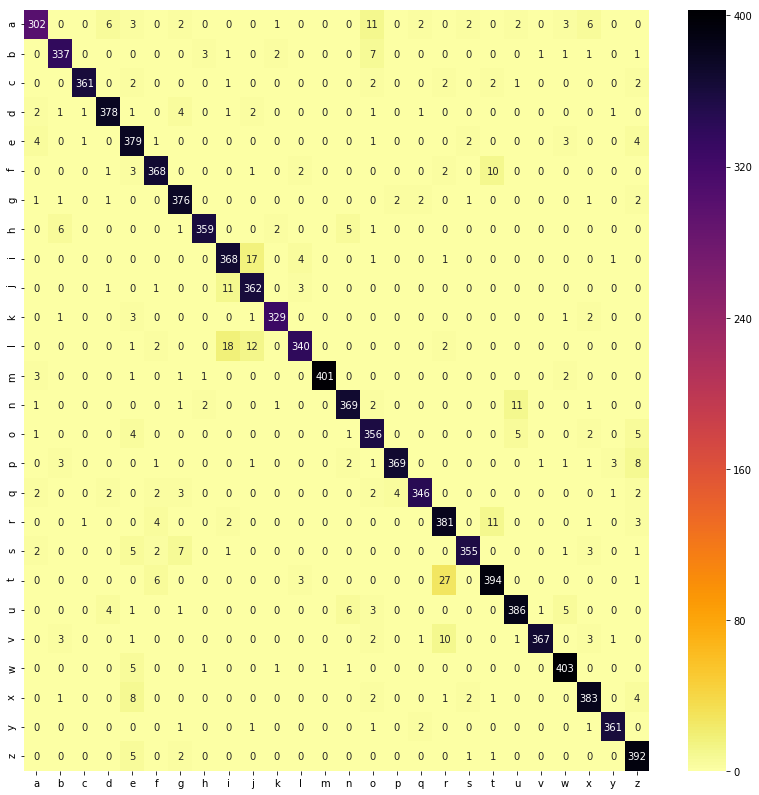

In [6]:
show_confusion_matrix(pred_labels, task='char')

## 2.2 Setting up the adversarial task

We will now use the output of the trained baseline model which is freezed as an input of another model called the `adversarial_model` which will try to predict on another task, namely the family recognition

There are little change compared to the usual test, train and main functions.

In [7]:
def adversarial_train(args, adversarial_model, model, train_loader, adv_optimizer, epoch):
    adversarial_model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = model.transform(data)  # <-- This is new
        adv_optimizer.zero_grad()
        output = adversarial_model(data)
        loss = F.nll_loss(output, target)

        loss.backward()
        adv_optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))


def adversarial_test(args, adversarial_model, model, test_loader):
    adversarial_model.eval()
    test_loss = 0
    correct = 0
    pred_labels = None
    with torch.no_grad():
        for data, target in test_loader:
            data = model.transform(data) # <-- This is new
            output = adversarial_model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            pred_labels_batch = torch.stack((pred, target.view_as(pred))).view(2, args.test_batch_size)
            if pred_labels is None:
                pred_labels = pred_labels_batch
            else:
                pred_labels = torch.cat((pred_labels, pred_labels_batch), dim=1).view(2, -1)

    test_loss /= len(test_loader.dataset)

    acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), acc))
    
    return acc, pred_labels.transpose(0, 1)


This is the Adversarial model that we will use. We use the same CNN structure as seen previously.

In [8]:
class AdversarialCNN(nn.Module):
    def __init__(self, output_size):
        super(AdversarialCNN, self).__init__()
        self.lin1 = nn.Linear(26, 784)
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, output_size)

    def forward(self, x):
        x = self.lin1(x)
        x = x.view(-1, 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [9]:
import torch.optim as optim
import torch.utils.data as utils

class Parser:
    def __init__(self):
        self.epochs = 10
        self.lr = 0.01
        self.momentum = 0.5
        self.seed = 1
        self.test_batch_size = 1000
        self.batch_size = 64
        self.no_cuda = False
        self.save_model = False
        self.log_interval = 300
        
def build_tensor_dataset(data, target):
    normed_data = [(d - d.mean()) / d.std() for d in data]
    normed_data = torch.stack([torch.Tensor(d).reshape(1, 28, 28) for d in normed_data])
    target = torch.LongTensor([i[0] for i in target])
    tensor_dataset = utils.TensorDataset(normed_data, target)
    return tensor_dataset
    

The base quadratic model is already trained to detect char, which it does not to badly.
We compute explicitely the weight sum of the quadratic model parameters to verify that this private model is left unchanged after the collateral learning phase.

In [10]:
quad_param_norm = quad_model.proj1.weight.norm() + quad_model.diag1.weight.norm()
quad_param_norm

tensor(9.5949, grad_fn=<AddBackward0>)

We new try to detect using its output, the family of the original input data.

In [11]:
data = learn.load_data()
train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data

Training set 60000 items
Testing set  10000 items


In [12]:
def adversarial_phase(model):
    args = Parser()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    # setting = the family recognition task
    train_dataset = build_tensor_dataset(train_data, train_target_family)
    test_dataset = build_tensor_dataset(test_data, test_target_family)
    adversarial_output_size = 5
    
    train_loader = utils.DataLoader(
        train_dataset,
        batch_size=args.batch_size, shuffle=True
    )
    
    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
    
    adversarial_model = AdversarialCNN(output_size=adversarial_output_size)
    adversarial_optimizer = optim.SGD(adversarial_model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs = []
    for epoch in range(1, args.epochs + 1):
        adversarial_train(args, adversarial_model, model, train_loader, adversarial_optimizer, epoch)
        acc, pred_labels = adversarial_test(args, adversarial_model, model, test_loader)
        test_perfs.append(acc)
        
    return test_perfs, pred_labels
        


In [13]:
test_perfs, pred_labels = adversarial_phase(quad_model)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.618377
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.955480
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.055913
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.682603

Test set: Average loss: 0.7344, Accuracy: 6976/10000 (69.76%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.715674
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.766397
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.664516
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.471019

Test set: Average loss: 0.7100, Accuracy: 7070/10000 (70.70%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.560507
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.678985
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.638161
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.632982

Test set: Average loss: 0.6778, Accuracy: 7205/10000 (72.05%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.662801
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.697922
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.530857
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.584230

Test set: Average loss: 0.5

The learning curve:

In [14]:
test_perfs

[69.76, 70.7, 72.05, 79.93, 79.11, 80.16, 79.49, 80.86, 81.86, 81.18]

### Discussion

First, let's verify that the private model weights have not changed

In [15]:
assert quad_param_norm == quad_model.proj1.weight.norm() + quad_model.diag1.weight.norm()

Second, one could ask the difference with the setting where we put a CNN (the same) on top of the private network to learn family recognition in Part 3. The major difference is that in Part 3 we could modify the private network weights, while here we couldn't, and moreover the weights were optimised to perform a completely different task!

Last, as this experiment shows, the prediction accuracy of the model is embarrassingly good! This shows that the information contained in the 26 neurons output is far more important than just information about characters. In particular, we can infer quite precisely information about the font of the original data.

For the sake of curiosity, we build the confusion matrix of the predictor and compare it to the one with the QuadNet only the the one with the QuadNet + CNN (See Part3).

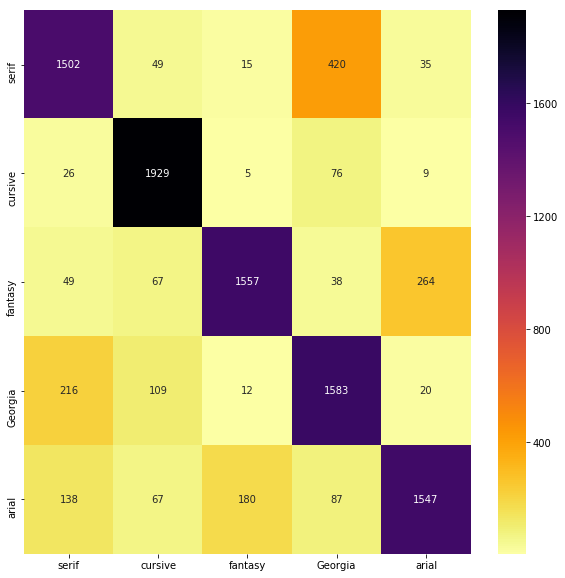

In [16]:
show_confusion_matrix(pred_labels, task='family')